In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("data/hrv_holter_features_time.csv")
y = df["died"].values
X = df.drop(["ID", "died"], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)
X.shape

(176, 25)

## Utils


In [3]:
from importlib import reload
import utils

reload(utils)

from utils import (
    preprocess,
    find_best_fold,
    calculate_metrics,
    plot_confusion_matrix,
    display_kfold_scores,
    apply_grid_search,
    extract_params_and_k,
    get_kfold_results,
    gmean_scorer,
    CorrelationFeatureReducer
)


from sklearn.decomposition import PCA

## Constants


In [4]:
MODEL_PREFIX = "clf"
K_KEY = "select__threshold"
REDUCTION_TYPE = "corr"

SELECTOR_MAP = {
    "kbest": SelectKBest(f_classif),
    "corr": CorrelationFeatureReducer(),
    "pca": PCA(),
}

SELECTOR = SELECTOR_MAP[REDUCTION_TYPE]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Logistic Regression


In [5]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("select", SELECTOR),
        ("clf", LogisticRegression(solver="liblinear", max_iter=1000, random_state=42)),
    ]
)

param_grid = {
    "select__threshold": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.],
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.001, 0.01, 0.1, 1, 10],
    "clf__class_weight": [None, "balanced"],
}

params = apply_grid_search(
    X_train, y_train, estimator=pipeline, param_grid=param_grid, scoring="f1"
)

best_params, best_k = extract_params_and_k(params, MODEL_PREFIX, K_KEY)

print(f"Best params: {best_params}")
print(f"Best k: {best_k}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best score: 0.43457875457875456
Best params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1'}
Best k: 0.3


In [6]:
X_train_, X_test_ = preprocess(
    X_train, X_test, y_train, k=best_k, reduction_type=REDUCTION_TYPE
)


model = LogisticRegression(
    solver="liblinear", max_iter=1000, random_state=42, **best_params
)
model.fit(X_train_, y_train)


y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test, y_pred, display=True)

Accuracy: 66.04
Precision: 50.00
Recall: 44.44
Specificity: 77.14
F1 Score: 47.06
Geometric Mean: 58.55


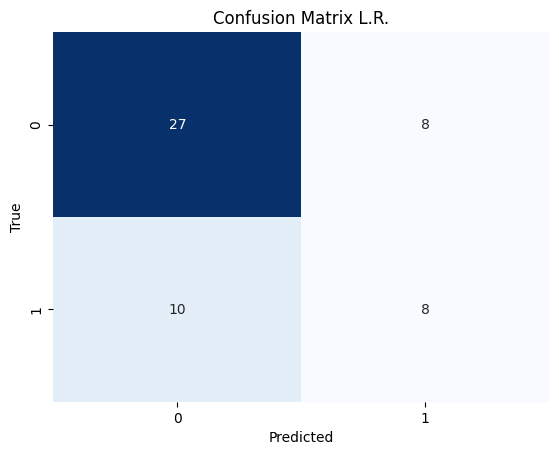

In [7]:
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix L.R.")

In [8]:
metrics = get_kfold_results(
    model=LogisticRegression(
        solver="liblinear", max_iter=1000, random_state=42, **best_params
    ),
    X=X_train,
    y=y_train,
    cv=cv,
    best_k=best_k,
    preprocess_reduction_type=REDUCTION_TYPE,
)

display_kfold_scores(metrics)

K-Fold Results
Accuracy: 67.53 ± 8.57
Precision: 49.14 ± 17.65
Recall: 39.44 ± 18.85
Specificity: 81.69 ± 3.76
F1 Score: 43.46 ± 18.67
Geometric Mean: 55.03 ± 15.88


In [9]:
best_fold, idx_best_fold = find_best_fold(
    cv.split(X_train, y_train), metrics, eval_metric="f1"
)
print(f"Best fold: {idx_best_fold + 1}")

train_idx, test_idx = best_fold
X_train_ = X_train[train_idx]
X_test_ = X_train[test_idx]
y_train_ = y_train[train_idx]
y_test_ = y_train[test_idx]

X_train_, X_test_ = preprocess(
    X_train_, X_test_, y_train_, k=best_k, reduction_type=REDUCTION_TYPE
)
model = LogisticRegression(
    solver="liblinear", max_iter=1000, random_state=42, **best_params
)
model.fit(X_train_, y_train_)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test_, y_pred, display=True)

Best fold: 2
Accuracy: 80.00
Precision: 71.43
Recall: 62.50
Specificity: 88.24
F1 Score: 66.67
Geometric Mean: 74.26


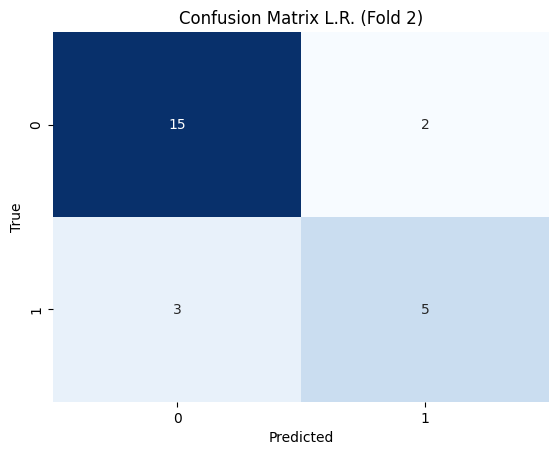

In [10]:
plot_confusion_matrix(
    y_test_, y_pred, title=f"Confusion Matrix L.R. (Fold {idx_best_fold + 1})"
)

## SVC


In [11]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("select", SELECTOR),
        ("clf", SVC(random_state=42)),
    ]
)

param_grid = {
    "select__threshold": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.],
    "clf__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "clf__gamma": ["scale", "auto"],
    "clf__class_weight": [None, "balanced"],
}

params = apply_grid_search(
    X_train, y_train, estimator=pipeline, param_grid=param_grid, scoring="f1"
)

best_params, best_k = extract_params_and_k(params, MODEL_PREFIX, K_KEY)

print(f"Best params: {best_params}")
print(f"Best k: {best_k}")

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best score: 0.4398343685300207
Best params: {'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'sigmoid'}
Best k: 0.7


In [12]:
X_train_, X_test_ = preprocess(
    X_train, X_test, y_train, k=best_k, reduction_type=REDUCTION_TYPE
)


model = SVC(random_state=42, **best_params)


model.fit(X_train_, y_train)


y_pred = model.predict(X_test_)


_ = calculate_metrics(y_test, y_pred, display=True)

Accuracy: 56.60
Precision: 40.00
Recall: 55.56
Specificity: 57.14
F1 Score: 46.51
Geometric Mean: 56.34


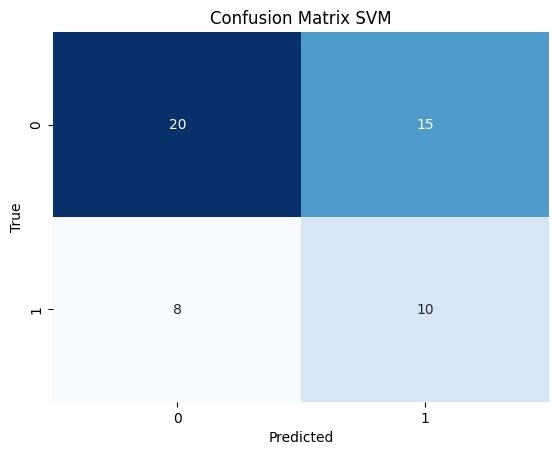

In [13]:
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix SVM")

In [14]:
metrics = get_kfold_results(
    model=SVC(random_state=42, **best_params),
    X=X_train,
    y=y_train,
    cv=cv,
    best_k=best_k,
    preprocess_reduction_type=REDUCTION_TYPE,
)

display_kfold_scores(metrics)

K-Fold Results
Accuracy: 53.63 ± 5.57
Precision: 36.51 ± 7.37
Recall: 55.56 ± 13.64
Specificity: 52.43 ± 4.38
F1 Score: 43.98 ± 9.62
Geometric Mean: 53.50 ± 7.01


In [15]:
best_fold, idx_best_fold = find_best_fold(
    cv.split(X_train, y_train), metrics, eval_metric="f1"
)
print(f"Best fold: {idx_best_fold + 1}")

train_idx, test_idx = best_fold
X_train_ = X_train[train_idx]
X_test_ = X_train[test_idx]
y_train_ = y_train[train_idx]
y_test_ = y_train[test_idx]

X_train_, X_test_ = preprocess(
    X_train_, X_test_, y_train_, k=best_k, reduction_type=REDUCTION_TYPE
)
model = SVC(random_state=42, **best_params)
model.fit(X_train_, y_train_)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test_, y_pred, display=True)

Best fold: 3
Accuracy: 64.00
Precision: 50.00
Recall: 77.78
Specificity: 56.25
F1 Score: 60.87
Geometric Mean: 66.14


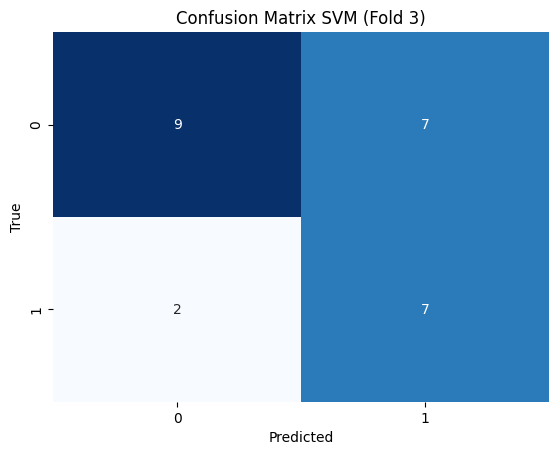

In [16]:
plot_confusion_matrix(
    y_test_, y_pred, title=f"Confusion Matrix SVM (Fold {idx_best_fold + 1})"
)

## KNN


In [17]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("select", SELECTOR),
        ("clf", KNeighborsClassifier()),
    ]
)

param_grid = {
    "select__threshold": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.],
    "clf__n_neighbors": [3, 5, 7, 9, 11, 13],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2, 3],
}

params = apply_grid_search(
    X_train, y_train, estimator=pipeline, param_grid=param_grid, scoring="f1"
)

best_params, best_k = extract_params_and_k(params, MODEL_PREFIX, K_KEY)

print(f"Best params: {best_params}")
print(f"Best k: {best_k}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best score: 0.4665656789031402
Best params: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Best k: 0.3


In [18]:
X_train_, X_test_ = preprocess(
    X_train, X_test, y_train, k=best_k, reduction_type=REDUCTION_TYPE
)

model = KNeighborsClassifier(**best_params)

model.fit(X_train_, y_train)

y_pred = model.predict(X_test_)

_ = calculate_metrics(y_test, y_pred, display=True)

Accuracy: 56.60
Precision: 30.77
Recall: 22.22
Specificity: 74.29
F1 Score: 25.81
Geometric Mean: 40.63


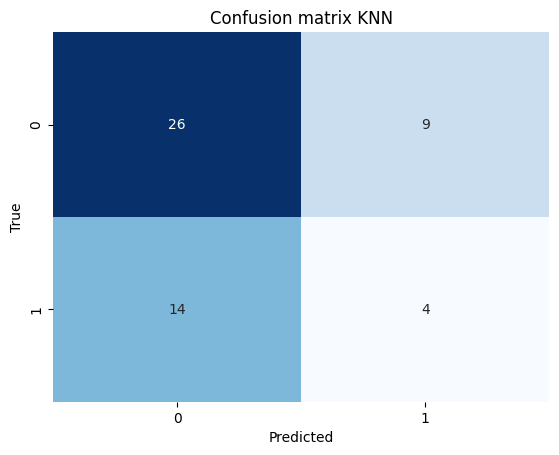

In [19]:
plot_confusion_matrix(y_test, y_pred, "Confusion matrix KNN")

In [20]:
metrics = get_kfold_results(
    model=KNeighborsClassifier(**best_params),
    X=X_train,
    y=y_train,
    cv=cv,
    best_k=best_k,
    preprocess_reduction_type=REDUCTION_TYPE,
)

display_kfold_scores(metrics)

K-Fold Results
Accuracy: 65.10 ± 6.28
Precision: 48.26 ± 9.38
Recall: 46.67 ± 13.02
Specificity: 74.41 ± 8.86
F1 Score: 46.66 ± 9.74
Geometric Mean: 58.13 ± 7.92


In [21]:
best_fold, idx_best_fold = find_best_fold(
    cv.split(X_train, y_train), metrics, eval_metric="f1"
)
print(f"Best fold: {idx_best_fold + 1}")

train_idx, test_idx = best_fold
X_train_ = X_train[train_idx]
X_test_ = X_train[test_idx]
y_train_ = y_train[train_idx]
y_test_ = y_train[test_idx]

X_train_, X_test_ = preprocess(
    X_train_, X_test_, y_train_, k=best_k, reduction_type=REDUCTION_TYPE
)
model = KNeighborsClassifier(**best_params)
model.fit(X_train_, y_train_)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test_, y_pred, display=True)

Best fold: 4
Accuracy: 75.00
Precision: 62.50
Recall: 62.50
Specificity: 81.25
F1 Score: 62.50
Geometric Mean: 71.26


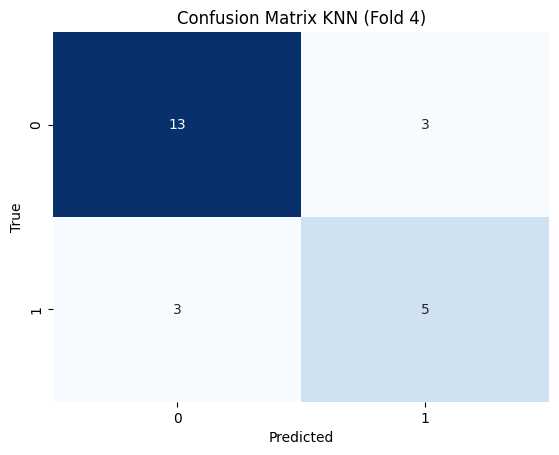

In [22]:
plot_confusion_matrix(
    y_test_, y_pred, title=f"Confusion Matrix KNN (Fold {idx_best_fold + 1})"
)